###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 二维SH有限差分建模 - Love波传播在Fossa Carolina canal

在前面的课程中分析了SH体波及其自由表面边界反射的准确性之后，我们现在能够建模SH面波(Love波)。我们不需要使用简化的合成地下模型，而是可以依靠中世纪运河上采集的现场数据集的全波形反演(FWI)结果。重建的Vs模型通过考古发掘得到了验证。

## The Fossa Carolina

德国基建优先计划 [SPP 1630 ”Harbours from the Roman Periods to the Middle Ages”](http://www.spp-haefen.de/en/home/) 的目标之一是位于德国南部的卡罗莱纳运河(Fossa Carolina)，在德语中也被称为查理曼高峰运河(Charlemagne’s Summit Canal)或卡尔斯格拉本运河(Karlsgraben)。最初由弗兰科国王查理曼倡议，作为一个3公里长的运河连接多瑙河和莱茵河系统，从而克服中欧流域，建设于公元793年在Schwäbische Rezat河和Altmühl河之间实现。
卡罗莱纳山是中世纪早期最重要的大型水利工程之一。自2012年以来，Fossa Carolina是跨学科研究的目标，涵盖了考古学、地理学和地球物理学等不同领域。基于Leibniz-IPHT Jena的大规模磁勘探，在2015年至2016年期间，采用地震、探地雷达(GPR)、电阻率层析成像(ERT)和Direct Push测量进行了更详细的调查。这些研究的目的是更详细地绘制运河基底深度图，以便更好地了解其利用情况。由于GPR测量的穿透深度有限，我们将重点放在沿Fossa Carolina样带采集的SH数据集的初至波走时层析成像(FATT)和全波形反演(FWI)结果上。

采集系统包含47个震源和48个水平分量的检波器，间距为0.75 m，最大偏移距为36 m。
采集到的数据范围为10 Hz ~ 90 Hz，信噪比高。由于现场数据的高质量，二维FWI只需要进行少量的数据预处理。 更多的细节可参考 [Dokter et al. (2017)](https://www.researchgate.net/publication/317336182_Full-waveform_inversion_of_SH-_and_Love-wave_data_in_near-surface_prospecting). 在本研究中，我们专注于Vs模型的单参数反演，同时保持Q和密度模型的固定。初始的S波速度模型由初至波走时层析成像，使用 Qs = 10 和 ρ = 2000 kg/m 3 。为了降低反问题的非线性，采用了不同带宽的低通和带通滤波数据的顺序FWI工作流程 [(Köhn et al., 2018)](https://www.researchgate.net/publication/324717049_Comparison_of_time-domain_SH_waveform_inversion_strategies_based_on_sequential_low_and_bandpass_filtered_data_for_improved_resolution_in_near-surface_prospecting).

2016年8月，沿着二维地震SH剖面开挖了Fossa Carolina运河。导出的草图和照片提供了一个独特的机会，可以直接将FWI结果与地下可见的真实结构进行比较。下面这张在挖掘过程中拍摄的照片显示了福萨卡罗莱纳运河在18.6米到24.0米之间的5.4米长的部分，沿着二维SH剖面向下到1.8米的深度。

<img src="images/FATT_FWI_comp_photo_final.jpg" width="100%">

它显示了层与层之间的渐变，除了非常清晰的运河地下室。深度断面上部40cm为由土壤和垂直裂缝组成的风化层。随着深度的增加，可以看到不同的黄色和灰色粘土层。在靠近挖掘底部的地方，部分富含有机质的黑色岩层被发现。为了直接比较FWI结果，我们将Vs模型的图像和等高线图叠加在开挖照片上。 FWI结果表明，密集的速度等值线改善了运河基底的定义，表明有显著的速度梯度。与经典的初至波走时层析成像(FATT)相比，在管腔内出现了一些明显的低速和高速异常([Köhn et al., 2018](https://www.researchgate.net/publication/324717049_Comparison_of_time-domain_SH_waveform_inversion_strategies_based_on_sequential_low_and_bandpass_filtered_data_for_improved_resolution_in_near-surface_prospecting), [Köhn et al., 2018a](https://www.researchgate.net/publication/325696342_2D_full_waveform_inversion_applied_to_a_strongly-dispersive_Love_wave_field_dataset_talk)). 在某些部分，照片的颜色可以直接与速度模型相关。例如，FWI的Vs模型的低速等高线与深黄色粘土层重合，而上面的高速异常与灰色粘土层相关。在风化层中，这种相关性不再那么明显，因为松散的土壤和深入的垂直裂缝导致剪切模量的降低。结果，引入了一些主要的近地表低速异常，深达40 cm。

对于推导出的Fossa Carolina的S波速度模型，我们现在将计算Love波的传播和频散 ... 

In [1]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

像往常一样，我们首先定义建模参数 ...

In [2]:
# Definition of modelling parameters
# ----------------------------------
nx = 744  # number of spatial gridpoints in x-direction
nz = 120  # number of spatial gridpoints in z-direction

dx = 0.05 # spatial gridpoint distance in x-direction
dz = dx   # spatial gridpoint distance in z-direction

# Define model filename
name_vs = "Fossa_Carolina/Fossa_Carolina_LBL.vs"

tmax = 0.5   # maximum recording time of the seismogram (s)

# acquisition geometry
xr = 25.5     # x-receiver position (m)
zr = 0.05     # z-receiver position (m)

xsrc = 17.5   # x-source position (m)
zsrc = 0.05    # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

isnap = 4  # snapshot interval (timesteps)

... 导入Fossa Carolina的S波速度模型 ...

In [3]:
# Open file and write binary data to vp
f = open(name_vs)
data_type = np.dtype ('float32').newbyteorder ('<')
vs = np.fromfile (f, dtype=data_type)

# Reshape (1 x nx*nz) vector to (nx x nz) matrix 
vs = vs.reshape(nx,nz)

... 画出Fossa Carolina模型:

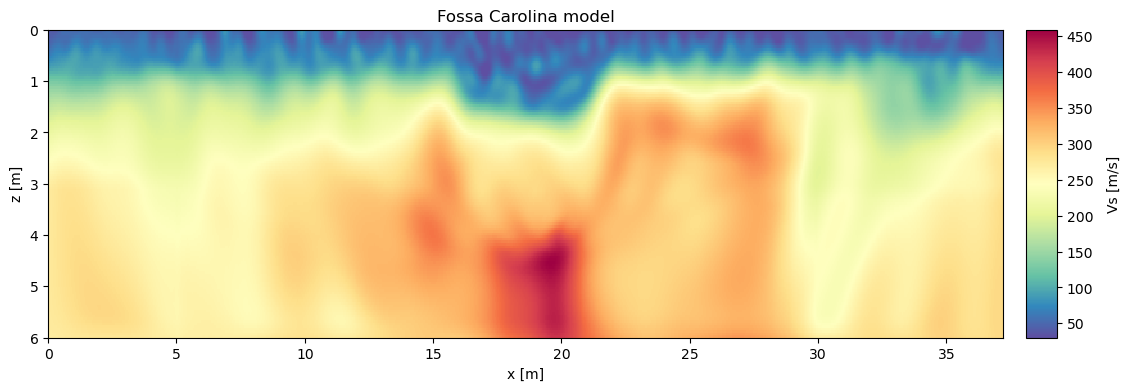

In [5]:
# Plot Fossa Carolina vs-model
# ----------------------------

# Define xmax, zmax and model extension
xmax = nx * dx
zmax = nz * dz
extent = [0, xmax, zmax, 0]

fig = plt.figure(figsize=(15,4))  # define figure size

image = plt.imshow((vs.T), cmap=plt.cm.Spectral_r, interpolation='nearest', 
                   extent=extent, aspect=2)

cbar = plt.colorbar(aspect=10, pad=0.02)
cbar.set_label('Vs [m/s]', labelpad=10)
plt.title('Fossa Carolina model')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.show()

注意模型顶部的低速层和运河内的小尺度特征，这可能与考古挖掘照片部分相关。除了Vs模型，有限差分代码还需要一个密度模型。 由于密度模型的影响小，我们可以使用一个简单的均匀密度模型 $\rho = 1800\; kg/m^3$ 典型的近表层土壤 ...

In [6]:
rho = 1800.0 * (vs / vs)

下一步，我们定义粒子速度 $v_y$ 的更新函数 ...

In [7]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho):
    
    # 2nd order FD operator   
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):

            # Calculate spatial derivatives  (2nd order operator)           
            syx_x = (syx[i,j] - syx[i - 1,j]) / dx
            syz_z = (syz[i,j] - syz[i,j - 1]) / dz

            # Update particle velocities
            vy[i,j] = vy[i,j] + (dt/rho[i,j]) * (syx_x + syz_z)                               
                
    return vy

... 更新剪应力分量 $\sigma_{yx}$ 和 $\sigma_{yz}$ ...

In [8]:
# Shear stress syx, syz updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz):
    
    # 2nd order FD operator
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):

            # Calculate spatial derivatives (2nd order operator)
            vy_x = (vy[i + 1,j] - vy[i,j]) / dx
            vy_z = (vy[i,j + 1] - vy[i,j]) / dz

            # Update shear stresses
            syx[i,j] = syx[i,j] + dt * mux[i,j] * vy_x
            syz[i,j] = syz[i,j] + dt * muz[i,j] * vy_z                    
    
    return syx, syz

... 和剪切模量谐波平均 ...

In [9]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate harmonic averages of shear moduli        
            mux[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])
            muz[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
            
    return mux, muz

为了避免来自底部以及左右边界的边界反射，我们使用了简单的海绵边界框架，这是为二维声学代码引入的，可参见 [这节课](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/4_fdac2d_absorbing_boundary.ipynb):

In [10]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

最终, 把它们加入到主代码中:

In [11]:
# 2D SH Wave Propagation (Finite Difference Solution) 
# ---------------------------------------------------
def FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs,rho):        
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # define wavefield clip value    
    clip = 1e-5
    
    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate 2D Green's function for direct SH wave from source position    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction            
    
    # Initialize empty pressure arrays
    # --------------------------------
    vy    = np.zeros((nx,nz)) # particle velocity vy
    syx   = np.zeros((nx,nz)) # shear stress syx
    syz   = np.zeros((nx,nz)) # shear stress syz        
    
    # define shear modulus
    # --------------------
    mu = rho * vs**2
    
    # harmonic average of shear moduli
    # --------------------------------
    mux   = mu # initialize harmonic average mux 
    muz   = mu # initialize harmonic average muz

    mux, muz = shear_avg(mu, nx, nz, mux, muz)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Initalize animation of vy wavefield 
    # -----------------------------------
    fig = plt.figure(figsize=(7,3))  # define figure size
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot Vp-model
    image = plt.imshow((vs.T), cmap=plt.cm.gray, interpolation='nearest', 
                        extent=extent, aspect=2)    
    
    # Plot vy wavefield movie
    image1 = plt.imshow(vy.T, animated=True, cmap="RdBu", alpha=.75, extent=extent, 
                          interpolation='nearest', aspect=2, vmin=-clip, vmax=clip)
    
    plt.title('Vy wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
           
    plt.ion()    
    plt.show(block=False)
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho)

        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc,jsrc] = vy[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dx * dz))
        
        # Apply absorbing boundary frame to vy
        # ------------------------------------
        vy *= absorb_coeff        
        
        # Update shear stress syx, syz
        # ----------------------------
        syx, syz = update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz)                
        
        # Apply absorbing boundary frame to syx, syz
        # ------------------------------------------
        syx *= absorb_coeff
        syz *= absorb_coeff
        
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir,jr]
        
        # display vy snapshots 
        if (it % isnap) == 0:            
            image1.set_data(vy.T)
            fig.canvas.draw()
        
    return time, seis

我们首先对具有福萨卡罗莱纳模型的平均横波速度和恒定密度的均匀模型的波传播和地震记录进行建模 $\rho = 1800\; kg/m^3$ 

nt =  3369


<IPython.core.display.Javascript object>


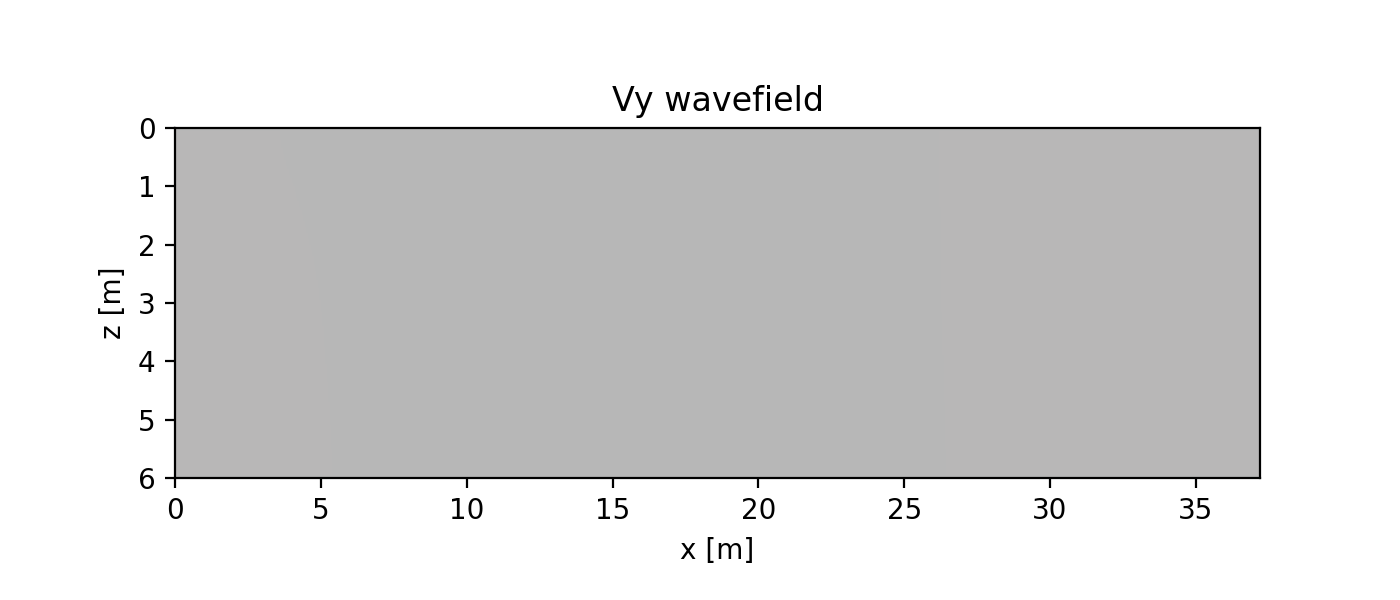

In [12]:
# Run SH FD modelling for homogeneous model
# -----------------------------------------
%matplotlib notebook

# define homogeneous model
vs0 = np.mean(vs) * (vs / vs)
rho0 = 1800.0 * (vs / vs)

# calculate time step according to CFL criterion
dt = dx / (np.sqrt(2) * np.max(vs0)) 

time, seis_hom = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs0,rho0)

<IPython.core.display.Javascript object>


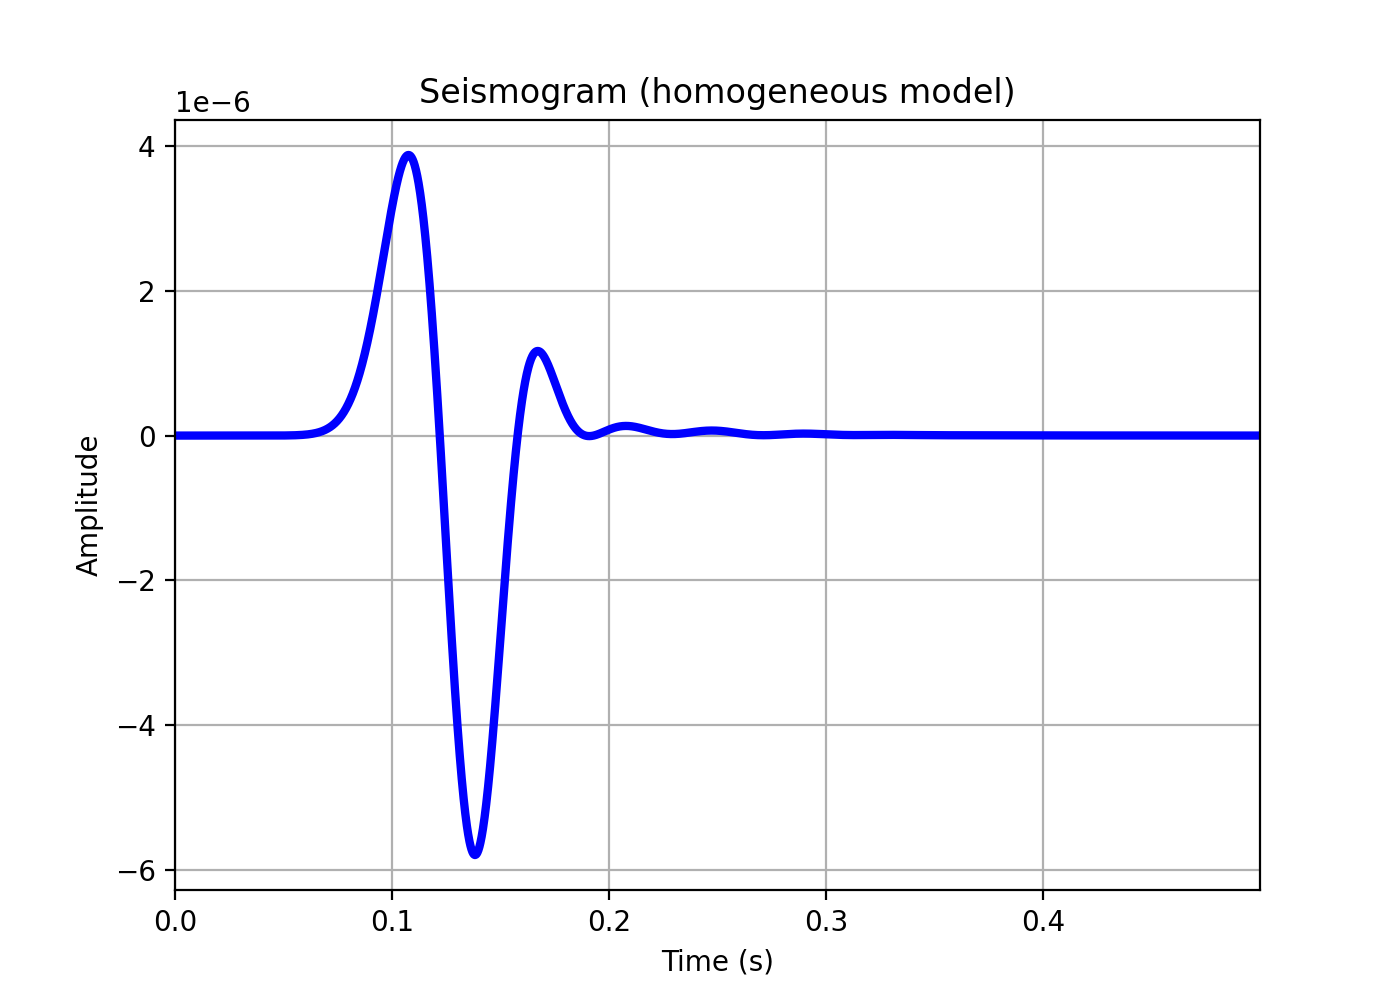

In [17]:
# Plot FD Seismogram
# ------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time, seis_hom, 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time[0], time[-1])
plt.title('Seismogram (homogeneous model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

即使模型中包含一个自由曲面，也没有Love波在均匀模型中传播。我们只看到直接的SH体波。理解Love波的起源和传播的一种方法是利用分层介质中SH体波的干扰，这就解释了为什么在均匀介质中Love波不传播。 在“地震波理论”一讲中，对这个问题给出了更为详细的数学描述 [(Müller 2007)](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:8728:5/component/escidoc:8727/0703.pdf).

所以让我们转向非均匀的Fossa Carolina运河模型，在这个模型中，地震波场应该是由Love波主导的:

nt =  6487


<IPython.core.display.Javascript object>


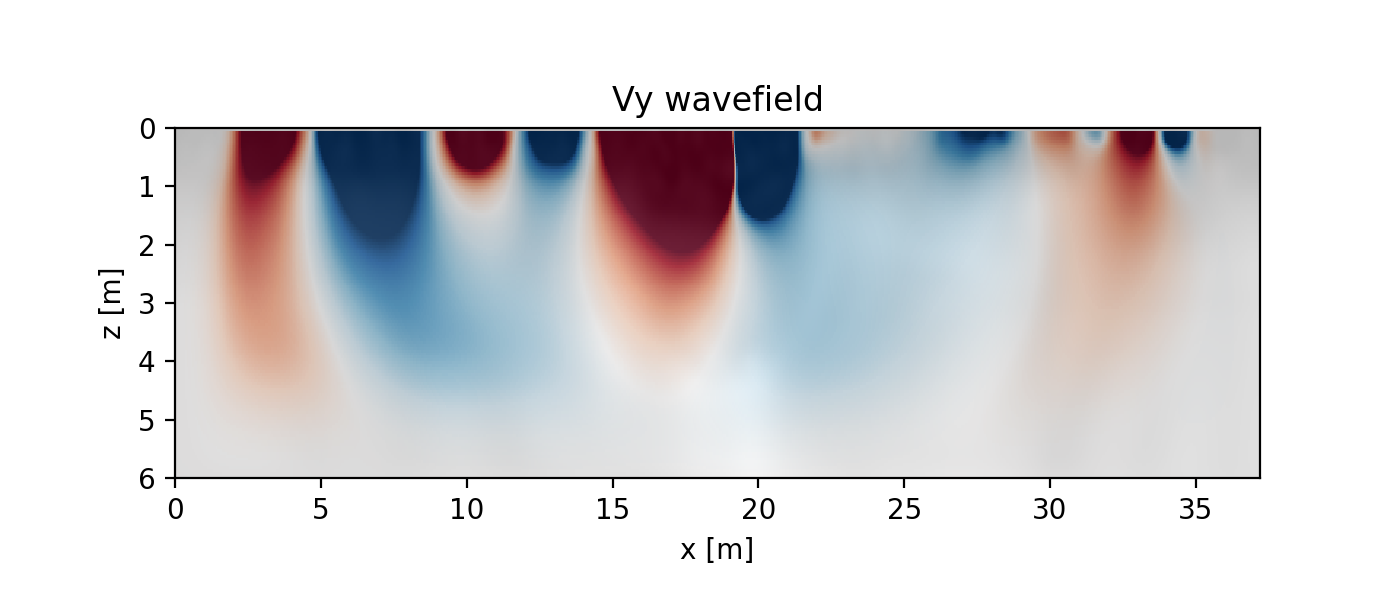

In [20]:
# Run SH FD modelling for heterogeneous Fossa Carolina canal model
%matplotlib notebook
# calculate time step according to CFL criterion
dt = dx / (np.sqrt(2) * np.max(vs)) 

time, seis_fossa = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs,rho)

<IPython.core.display.Javascript object>


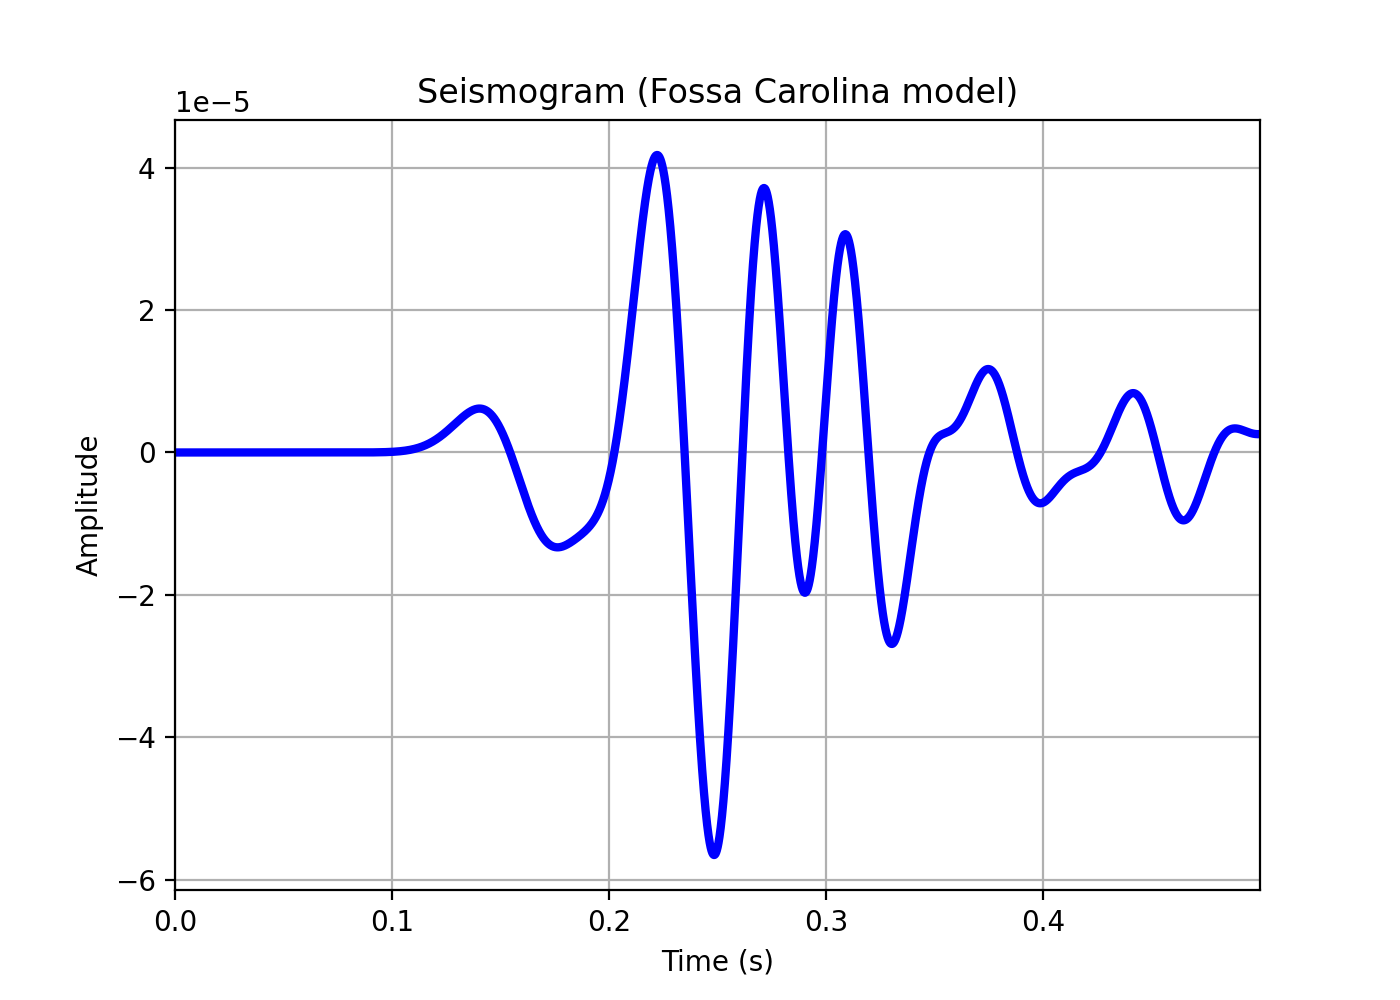

In [19]:
# Plot FD Seismogram
# ------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time, seis_fossa, 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time[0], time[-1])
plt.title('Seismogram (Fossa Carolina model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

哇，一个相当令人印象深刻的分散的Love波粘附在模型顶部的自由表面上，低频部分渗透到3米深，而高频的Love波在上部1米传播。还要注意均匀模型中的直接SH体波(6e-6米/秒)和非均匀的福萨卡罗莱纳运河中的Love波(6e-5米/秒)的地震图的振幅差异.

##### Excercise

You might wonder why we used such a simple homogeneous density model despite the heterogeneous sub-surface. To investigate the impact of a realistic heterogeneous density model on the Love-wavefield, compute a heterogeneous density model for the Fossa Carolina canal based on the Vs-model with an empirical density $\rho$ - S-wave velocity model $V_s$ relation from [Ulugergerli & Uyanık (2007)](https://www.researchgate.net/publication/249958795_Statistical_Correlations_Between_Seismic_Wave_Velocities_and_SPT_Blow_Counts_and_the_Relative_Density_of_Soils):

\begin{equation}
\rho = 0.1055\; ln(V_s)\; +\; 1.3871\notag
\end{equation}

with the units for $V_s$ $[m/s]$ and density $\rho$ $[g/cm^3]$. Compute the Love-/SH-wavefield for the Fossa Carolina canal model with the heterogeneous density model and compare the resulting seismograms with the previous result for the homogeneous density model. Discuss differences and similarities.

## 我们学习到:

* 二维SH问题的简单海绵边界的实现
* Love波在均匀的SH介质中不传播
* 弥散的Love波在非均匀的Fossa Carolina运河模型中传播，其中传播深度与频率相关